# Исследование рынка видеоигр

**Описание проекта**  
Интернет-магазине продаёт по всему миру компьютерные игры.  
Доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.  

Нужно выявить закономерности, определяющие успешность игры.  

Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  
Представим, что сейчас декабрь 2016 г., нужно спланировать кампанию на 2017-й. 

## Изучение данных из файла

**Описание данных**  

    Name — название игры
    Platform — платформа
    Year_of_Release — год выпуска
    Genre — жанр игры
    NA_sales — продажи в Северной Америке (миллионы проданных копий)
    EU_sales — продажи в Европе (миллионы проданных копий)
    JP_sales — продажи в Японии (миллионы проданных копий)
    Other_sales — продажи в других странах (миллионы проданных копий)
    Critic_Score — оценка критиков (максимум 100)
    User_Score — оценка пользователей (максимум 10)
    Rating — рейтинг от организации ESRB. Эта ассоциация присваивает играм подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

In [1]:
#импорт библиотек
import pandas            as pd
import numpy             as np

import matplotlib.pyplot as plt
import seaborn           as sns
from scipy import stats  as st

import warnings
warnings.filterwarnings('ignore')

In [2]:
# чтение файлов с данными и сохранение в переменную
df = pd.read_csv('/datasets/games.csv')

In [3]:
#Функция выводит общую информацию о датафрейме:
# - первые 5 строк датафрейма,
# - инфо о количестве записей,       кол-ве столбцов и типе данных в них,
# - долю пропущенных значений в %,   кол-во явных дубликатов.
def data_info(df):
    display(df.head(3))
    df.info()
    print()
    print('\033[1m' + 'Доля пропусков в %:')
    display(pd.DataFrame(round((df.isna().mean() * 100),2)).style.background_gradient('coolwarm'))
    print('\033[1m' + 'Количество явных дубликатов:', df.duplicated().sum())

In [4]:
#посмотрим на общую информацию о датафрейме
data_info(df)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB

Доля пропусков в %:


,0
Name,0.010000
Platform,0.000000
Year_of_Release,1.610000
Genre,0.010000
NA_sales,0.000000
EU_sales,0.000000
JP_sales,0.000000
Other_sales,0.000000
Critic_Score,51.320000
User_Score,40.090000


Количество явных дубликатов: 0


**Вывод**  
Критичные параметры, год выпуска, название, жанр,  
содержат незначительную долю пропусков (1,61%,  0,01% и 0,01% соотвественно),  
уберем эти строки из датафрейма.

Есть много пропусков в важных данных  
(оценка критиков, оценка пользователей, рейтинг), их нужно рассмотреть отдельно.

## Подготовка данных

### Обработка столбцов, типов данных, пропусков

In [5]:
#приведем названия столбцов к нижнему регистру
#df.columns = df.columns.str.lower()
df.columns = [x.lower() for x in df.columns]

In [6]:
#переименуем столбцы для сокращения места на экране;
df = df.rename(columns={'year_of_release':'year'})

In [7]:
#уберем строки с пропусками в столбцах год выпуска, название, жанр
df = df[ ~( (df['year'].isna()) | (df['name'].isna())| (df['genre'].isna()) )]

Год в этих данных нужно преобразовать в целое число, т.к. нет значений месяцев и дней.  
(Если бы были, и если это было нужно - преобразовали бы в тип 'дата'.)

In [8]:
#посмотрим уникальные значения столбца year
df['year'].sort_values().unique()

array([1980., 1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988.,
       1989., 1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997.,
       1998., 1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006.,
       2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015.,
       2016.])

In [9]:
#преобразование столбца 'год выхода' в int
df['year'] = df['year'].astype('int')

Столбец 'рейтинг' содержит строковые значения категориальной переменной.  

«EC» - Early childhood (дошкольники),  
«E» - Everyone (для всех возрастов),  
«K-A» - Kids to Adults - был заменён на «Everyone» 1 января 1998 г.,   
«E10+» - Everyone 10 and older (от 10 лет и выше),    
«T» - Teen (от 13 лет и выше),  
«M» - Mature (от 17 лет и выше),  
«AO» - Adults Only 18+ (только для взрослых, от 18 лет и выше),  
«RP» - Rating Pending (рейтинг еще не присвоен).  

В соответствии с логикой рейтинга заменим пропуски на значение «RP» (рейтинг ожидается),  
и значение «K-A» на «E», т.к. это неявный дубликат.

In [10]:
#посмотрим уникальные значения столбца rating
df['rating'].sort_values().unique()

array(['AO', 'E', 'E10+', 'EC', 'K-A', 'M', 'RP', 'T', nan], dtype=object)

In [11]:
#заполним пропуски в 'рейтинг' значением RP (рейтинг ожидается)
df['rating'] = df['rating'].fillna('RP')

In [12]:
#заменим значение «K-A» на «E», т.к. это неявный дубликат
df.loc[ df['rating'] == 'K-A', 'rating'] = 'E'

In [13]:
#Функция возвращает числовое значение рейтинга.
#Переменная   - rating строковое значение рейтинга.
#
def rating_to_int(rating):
    try:    
        if rating == 'EC':
            return 1
        elif rating == 'E':
            return 2
        elif rating == 'E10+':
            return 3
        elif rating == 'T':
            return 4
        elif rating == 'M':
            return 5
        elif rating == 'AO':
            return 6
       
        return 0
    except:
        print('error of rating category')

In [14]:
#переведем строковые значения категориальной переменной 'рейтинг' в числовые, запишем в новый столбец
df['rating_int'] = df['rating'].apply(rating_to_int)

Столбец 'оценка критиков' содержит числовые данные, но после запятой нет цифр,  
можно было бы преобразовать в int, но присутствие пропусков не дает это сделать.  
Пропуски здесь заполнять нельзя, т.к. любое заполнение исказит результаты корреляционного анализа и статтеста.

In [15]:
#посмотрим уникальные значения столбца critic_score
df['critic_score'].sort_values().unique()

array([13., 17., 19., 20., 21., 23., 24., 25., 26., 27., 28., 29., 30.,
       31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43.,
       44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
       57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
       70., 71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82.,
       83., 84., 85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95.,
       96., 97., 98., nan])

Столбец 'оценка пользователей' содержит смешанные данные,  
но по логике названия и содержанию его нужно преобразовать во float.  

Строковое значение 'tbd' означает To Be Determined (будет определено) или To Be Decided (будет решено).  
Акроним служит для отметки неясностей или пропусков, поэтому заменим его пропуском.  
Пропуски здесь также нельзя заполнять какими-либо значениями,  
т.к. любое заполнение исказит результаты корреляционного анализа и статтеста.

In [16]:
#посмотрим уникальные значения столбца user_score
df['user_score'].sort_values().unique()

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

In [17]:
#заполним строковые значения в 'оценка пользователей' на пропуски
#df.loc[ df['user_score'] == 'tbd', 'user_score'] = float('nan')

In [18]:
#изменим тип стобца 'оценка пользователей' на числовой 
#строковые значения tbd заменятся на пропуски при errors='coerce' invalid parsing will be set as NaN
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16444 non-null  object 
 1   platform      16444 non-null  object 
 2   year          16444 non-null  int64  
 3   genre         16444 non-null  object 
 4   na_sales      16444 non-null  float64
 5   eu_sales      16444 non-null  float64
 6   jp_sales      16444 non-null  float64
 7   other_sales   16444 non-null  float64
 8   critic_score  7983 non-null   float64
 9   user_score    7463 non-null   float64
 10  rating        16444 non-null  object 
 11  rating_int    16444 non-null  int64  
dtypes: float64(6), int64(2), object(4)
memory usage: 1.6+ MB


**Возможные причины пропусков в данных:**
- данные отсутствуют, потому что в определенное время их не собирали,
- пользователь не указал сведения,
- иногда пропуски оставляют, рассчитывая на автозаполнение,
- человеческий фактор(опечатки),
- система сбора информации дала сбой
  (во время копирования, считывания, записи данных, изменения формата файла).

### Суммарные продажи каждой игры во всех регионах

In [20]:
#суммируем продажи по всем регионам, запишем в новый столбец
df.insert(8, 'copy_count', 0)
df['copy_count'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head(3)

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,copy_count,critic_score,user_score,rating,rating_int
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E,2
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,RP,0
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E,2


## Исследовательский анализ данных

### Сколько игр выпускалось в разные годы.

In [21]:
#сгруппируем выпущенные игры по годам
games_year = df.pivot_table(index='year', values='name', aggfunc='count')

#для удобства переименуем столбец с количеством игр
games_year.columns = ['game_cnt']

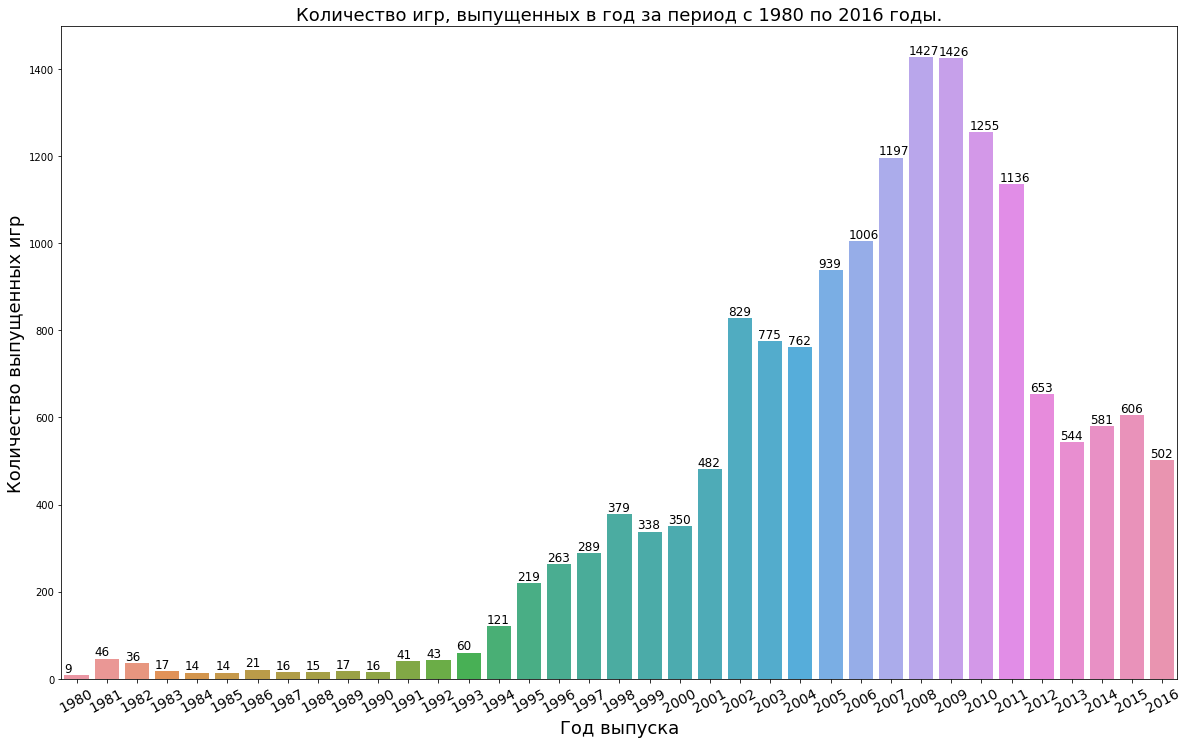

In [22]:
#визуализируем данные по количеству игр за год
plt.figure(figsize=(20,12) )

sns.barplot(games_year.index, y=games_year['game_cnt'])

plt.xticks(fontsize=14, rotation=28)

plt.xlabel('Год выпуска', fontsize=18)
plt.ylabel('Количество выпущенных игр',fontsize=18)
plt.title('Количество игр, выпущенных в год за период с 1980 по 2016 годы.',fontsize=18)

for x_pos, cnt in zip(np.arange(len(games_year.index)), games_year['game_cnt']):
    plt.annotate(cnt, xy=(x_pos-0.4, cnt), va='bottom', fontsize=12)
    
plt.show()

Количество игр выпущенных в год за период с 1980 по 1993 меньше сотни.  
Есть две точки, в которых наблюдается резкий рост ежегодно выпускаемых игр - это 1995 и 2002 годы,  
в них количество игр увеличвалось почти в два раза по сравнению с предыдущим годом.

Максимальное количество выпущено в 2008-2009 гг., после этого начинается небольшой спад в 2010-11 гг.  

Резкое снижение выпуска игр произошло в 2012 году - почти в два раза меньше, чем в предыдущие 4 года,  
в 2012 г спад продолжился, с 2012 по 2016 гг. количество игр колеблется около 600-500 игр в год.  

**Важны ли данные за все периоды?**  
Данные с 1980 по 1993 год включительно неважны, т.к. это ранний период развития индустрии.  
На данном графике их можно интерпретировать как выбросы. Без этого 'хвоста' распределение близко к нормальному.

### Как менялись продажи по платформам.

**Платформы с наибольшими суммарными продажами.**  

In [23]:
#сгруппируем продажи по каждой платформе за все года, выберем 10 платформ с max кол-ом продаж за весь период
top10_platform = df.pivot_table(index='platform', values='copy_count', aggfunc='sum')\
                   .sort_values(by='copy_count', ascending=False).head(10).reset_index()

#округлим сумму продаж до 2 знаков после запятой
top10_platform['copy_count'] = np.round(top10_platform['copy_count'],2)

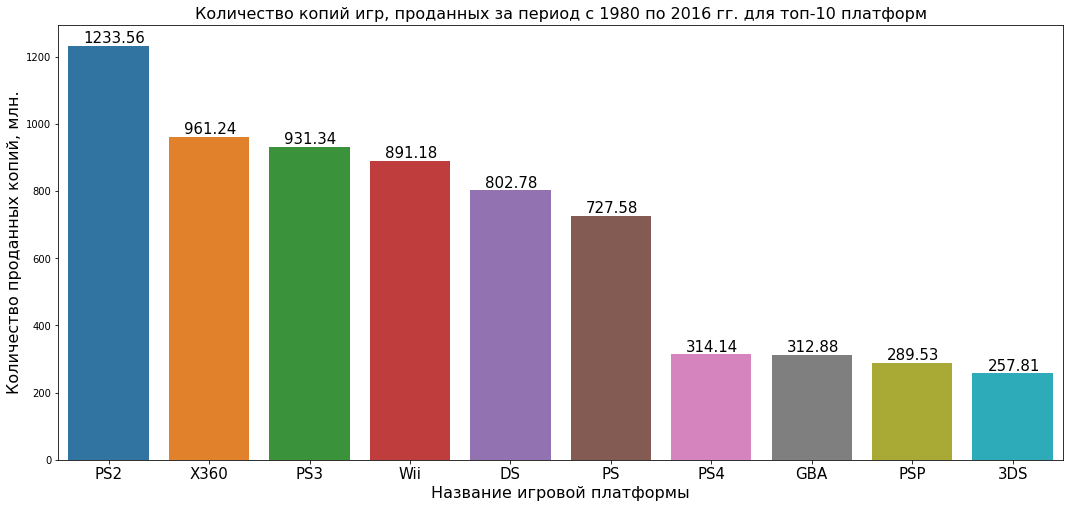

In [24]:
#визуализируем данные по количеству продаж за весь период для топ-10 платформ
plt.figure(figsize=(18,8) )

sns.barplot(top10_platform['platform'], y=top10_platform['copy_count'])

plt.xticks(fontsize=15)

plt.xlabel('Название игровой платформы', fontsize=16)
plt.ylabel('Количество проданных копий, млн.',fontsize=16)
plt.title('Количество копий игр, проданных за период с 1980 по 2016 гг. для топ-10 платформ',fontsize=16)

for x_pos, cnt in zip(np.arange(len(top10_platform)), top10_platform['copy_count']):
    plt.annotate(cnt, xy=(x_pos-0.25, cnt), va='bottom', fontsize=15)
    
plt.show()

Лидеры по суммарным продажам за все годы - PS2, X360, PS3, Wii, DS.  
Это довольно старые платформы, существующие с 2000, 2004-2006 гг.  
У относительно новых платформ PS4 (2013 г) и 3DS (2011 г) меньше всего суммарных продаж.

### Определение актуального периода.

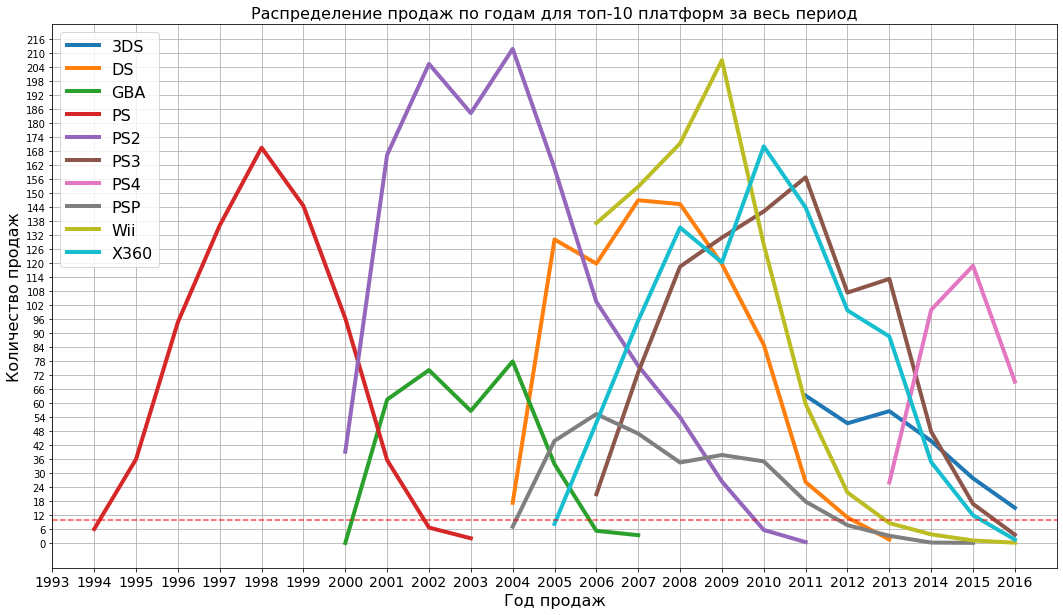

In [25]:
#Топ-10 платформ - распределение количества продаж по годам
top10 = top10_platform['platform']

df.query('platform in @top10').pivot_table(index='year',columns='platform',values='copy_count',aggfunc='sum')\
                              .plot(linewidth=4, grid=True, figsize=(18,10))

plt.xticks(list(df['year'].unique()), fontsize=14)
plt.xlim(1993,2017)
plt.yticks(list(range(0,222,6)))

plt.axhline(10, ls = '--', color ='red', alpha = 0.7)

plt.title('Распределение продаж по годам для топ-10 платформ за весь период',fontsize=16)
plt.xlabel('Год продаж',fontsize=16)
plt.ylabel('Количество продаж',fontsize=16)
plt.legend(fontsize=16)

plt.show()

**За какой характерный срок появляются новые и исчезают старые платформы?**  
График распределения продаж почти для всех консолей (за исключением 3DS) похож на колокол.  
Т.е., в первые годы выпуска консоли продажи игр под нее растут, после достижения пика - снижаются.  

Возьмем за минимальный порог продаж 10 млн. копий в год.  
Посчитаем среднее время жизни как число лет, в которых продажи больше или равны этому значению.  
Будем считать за актуальный период годы в середине этого колокола, т.е. половину среднего времени жизни игровой платформы.

In [26]:
min_sales = 10 #порог продаж в год - 10 млн копий
#
report = df.groupby(['platform', 'year']).agg({'copy_count':'sum'})\
           .query('copy_count >= @min_sales').reset_index()

life_cycle = report.groupby('platform').agg({'year':'nunique'}).median()
print('Среднее время жизненного цикла игровой платформы -', life_cycle['year'], 'лет.')
print('Актуальный период для анализа данных -', life_cycle['year']/2, 'года.')

Среднее время жизненного цикла игровой платформы - 6.0 лет.
Актуальный период для анализа данных - 3.0 года.


Т.к. данные за 2016 год могут быть неполными, дальнейший анализ будет проведен по 2013-2015 гг. включительно.

In [27]:
#отфильтруем данные по годам
df_cut = df.query('2013<=year<=2015')

### Какие платформы лидируют по продажам, растут или падают.  
**Выбор нескольких потенциально прибыльных платформ.**  


In [28]:
leader = {}
for year in range(2013,2016):
    leader[year]= (df_cut.query('year == @year').groupby('platform').agg({'copy_count': 'sum'})
                         .sort_values(by='copy_count').tail(1).reset_index().values[0])
    
    print('Лидирующая платформа в',year,'году:', leader[year])

Лидирующая платформа в 2013 году: ['PS3' 113.24999999999999]
Лидирующая платформа в 2014 году: ['PS4' 99.99999999999996]
Лидирующая платформа в 2015 году: ['PS4' 118.90000000000008]


In [29]:
#топ 10 платформ для периода 2013-2015 гг
top10_plat = df_cut.groupby('platform').agg({'copy_count': 'sum'})\
              .sort_values(by='copy_count', ascending = False).head(10).reset_index()

#список топ-10 платформ 2013-2015 гг
top10 = top10_plat['platform']

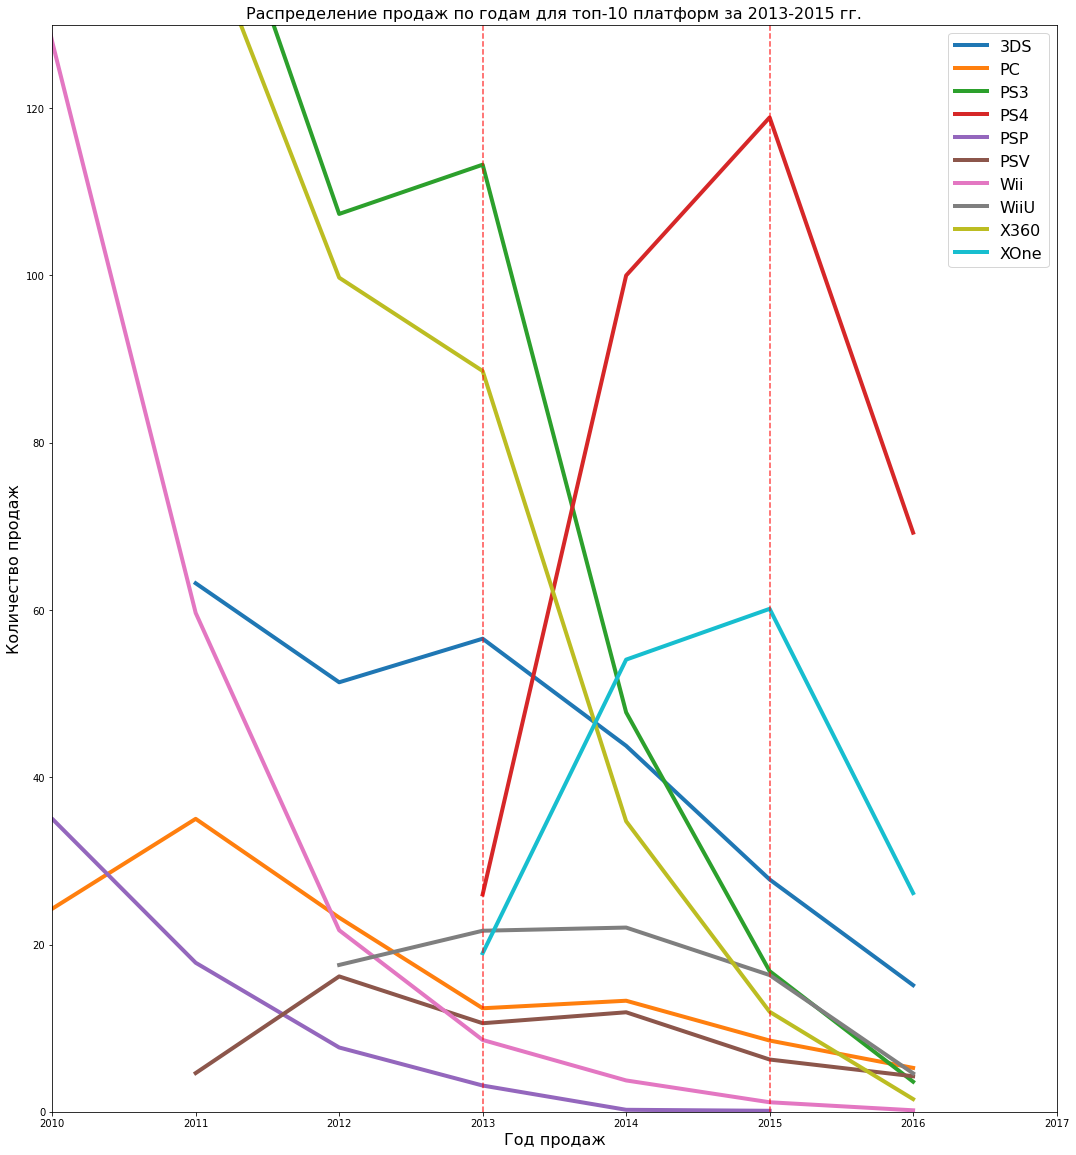

In [30]:
#берем данные из исходного датафрейма, чтобы взять года по краям, но фильтруем по топ-10 платформ 2013-2015 гг
df.query('platform in @top10')\
      .pivot_table(index='year', columns='platform', values='copy_count', aggfunc='sum')\
      .plot(linewidth=4, figsize=(18,20))

#plt.xticks(list(df['year'].unique()), fontsize=14)
plt.xlim(2010,2017)
plt.ylim(0,130)
#plt.yticks(list(range(0,126,6)))
plt.axvline(2013, ls = '--', color ='red', alpha = 0.7)
plt.axvline(2015, ls = '--', color ='red', alpha = 0.7)

plt.title('Распределение продаж по годам для топ-10 платформ за 2013-2015 гг.',fontsize=16)
plt.xlabel('Год продаж',fontsize=16)
plt.ylabel('Количество продаж',fontsize=16)
plt.legend(fontsize=16)

plt.show()

Взяты данные с 2010 г для лучшеей читаемости графика.  
Растущие платформы на промежутке 2013-2014 гг. - PC, PSV и WiiU, в 2015 г они падают.  

Растущие платформы на промежутке 2013-2015 гг. - PS4 и XOne.  

У платформы PSP последние продажи были в 2015 г.  
Остальные платформы падают на промежутке 2013 - 2015 гг.  

**Вывод**  
На всем рынке видеоигр в 2013-2015 гг. наблюдается спад продаж.  
В качестве потенциально прибыльных можно рассматривать игровые платформы PS4 и XOne.

### Глобальные продажи игр в разбивке по платформам.  
**Диаграмма 'ящик с усами' по данным за 2013-2015 гг., для топ-10 платформ по количеству проданных игр.**

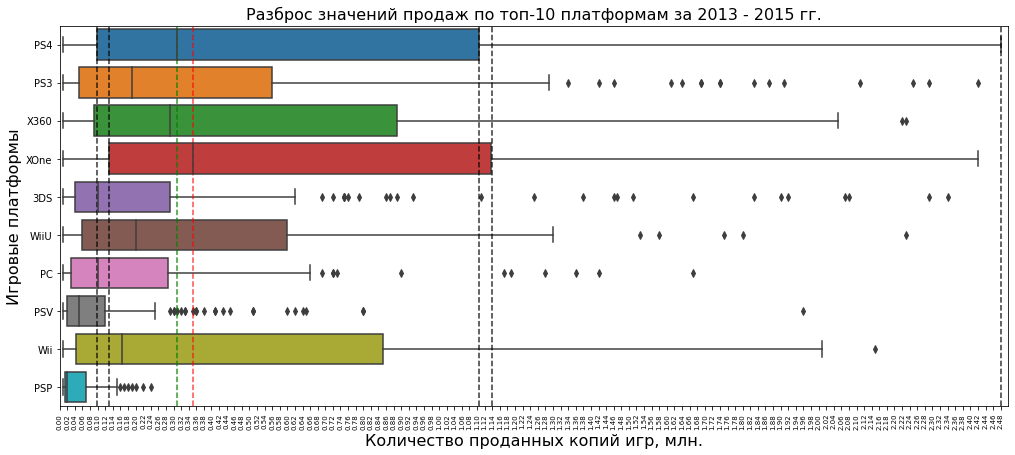

In [31]:
#диаграмма 'ящик с усами' по данным за 2013-2015 для топ-10 платформ по количеству проданных игр
plt.figure(figsize=(17,7))

order = top10_plat['platform']

sns.boxplot(data = df_cut.query('platform in @top10'),y = 'platform', x = 'copy_count', order = order)

plt.xticks(np.arange(0, 2.5, 0.02), fontsize=7, rotation=90)
plt.xlim(0, 2.5)

plt.title('Разброс значений продаж по топ-10 платформам за 2013 - 2015 гг.',fontsize=16)
plt.xlabel('Количество проданных копий игр, млн.',fontsize=16)
plt.ylabel('Игровые платформы',fontsize=16)

#медианы
plt.axvline(0.35, ls = '--', color ='red', alpha = 0.7)
plt.axvline(0.31, ls = '--', color ='green', alpha = 0.8)

#Xone
plt.axvline(0.13, ls = '--', color ='black', alpha = 0.8)
plt.axvline(1.14, ls = '--', color ='black', alpha = 0.8)

#PS4
plt.axvline(0.098, ls = '--', color ='black', alpha = 0.8)
plt.axvline(1.105, ls = '--', color ='black', alpha = 0.8)
plt.axvline(2.48, ls = '--', color ='black', alpha = 0.8)

plt.show()

In [32]:
top10_plat

,platform,copy_count
0,PS4,244.89
1,PS3,177.83
2,X360,135.28
3,XOne,133.17
4,3DS,128.11
5,WiiU,60.03
6,PC,34.18
7,PSV,28.74
8,Wii,13.48
9,PSP,3.50


Платформы отсортированы по убыванию суммарного количества продаж.  

XOne показывает самые высокие значения медианы и границ 2 и 3 квантиля из всех:  
50% значений продаж находятся в диапазоне примерно 130 000 - 1 140 000 копий.  
Медиана - 360 000 копий.  

50% значений PS4 находятся в диапазоне примерно 98 000 - 1 105 000 копий.  
Максимальное нормальное значение самое высокое среди всех платформ - примерно 2 480 000 копий.  
Медиана - 310 000 копий.  
Почти совпадающие межквантильный размах и медиана означают, что средние значения продаж у этих платформ очень близки.  

Самый большой разброс количества продаж у PS4, XOne, X360 и Wii.  

У X360 и Wii значения границ 3 квантиля и верхних нормальных значений примерно на 25% меньше, чему у PS4 и XOne.  
При этом медиана X360 чуть меньше медианы PS4, а медиана у Wii гораздо меньше чем у  PS4, X360, XOne.  
Т.е., средние значения продаж вторые по размерам среди всех у X360 и Wii.  

Большая вариабельность данных говорит о том, что есть игры кардинально различающиеся по популярности.  

Самые маленькие диаграммы у PSP и PSV - средние значения продаж самые низкие и колеблются в небольшом диапазоне.   

Положение медианы ближе к левой границе ящика, длинный правый ус и выбросы у всех распределений показывают,  
что все они скошены вправо.  
Это можно интерпретировать так, что на всех платформах есть небольшое число лидеров продаж,  
сильно оторвавшихся от основной массы игр.  
Из-за скошенности вправо среднее арифметическое количества проданных копий больше медианы.  

**Вывод**  
Данные по продажам сильно изменчивы.  
Данные по всем платформам скошены вправо, это значит, что есть несколько игр-лидеров по количеству продаж.  
Самые высокие средние продажи у XOne и PS4, на втором месте  - X360 и Wii.  
Даннные по количеству продаж потенциально прибыльных XOne и PS4 за 2013-2015 гг. очень близки.

### Влияние отзывов пользователей и критиков на продажи  
**Диаграмма рассеяния и подсчет корреляции между отзывами и продажами.**

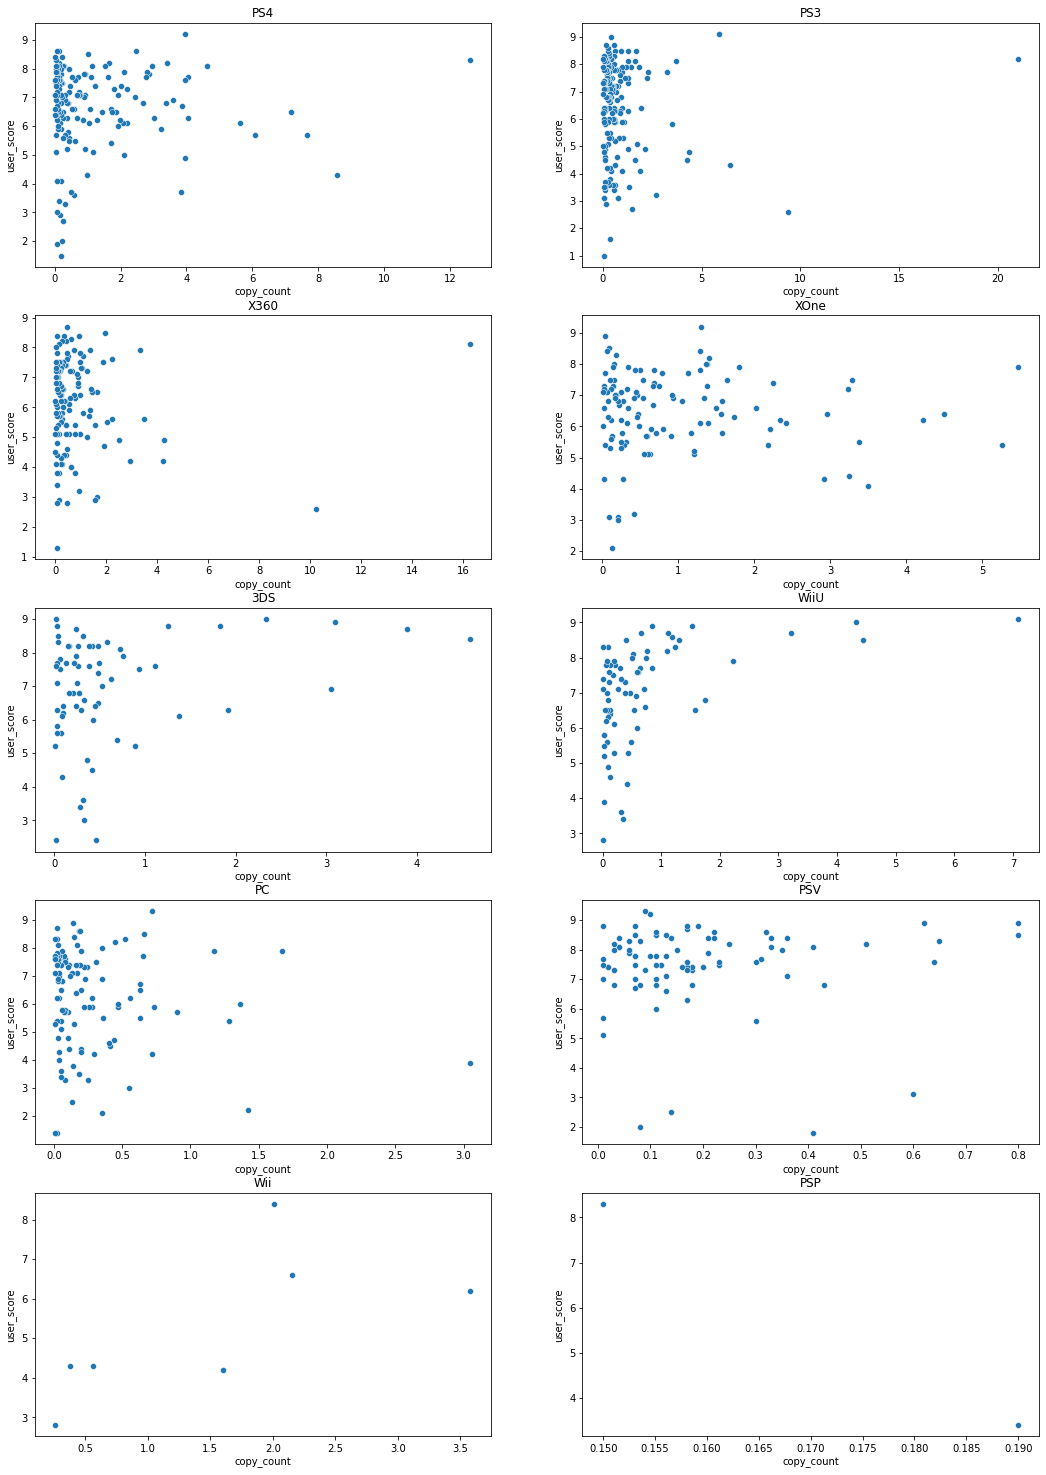

In [33]:
#диаграммы рассеяния для топ-10 платформ - зависимость м/у оценками пользователей и продажами
plt.figure(figsize=(18,26))
for i, platform in enumerate(top10):
    
    plt.subplot(5, 2, i+1)
    #df_cut.query('platform ==@platform').plot(x='copy_count', y='user_score', kind='scatter')
    sns.scatterplot(data=df_cut.query('platform ==@platform'), x='copy_count', y='user_score')
    plt.title(platform)

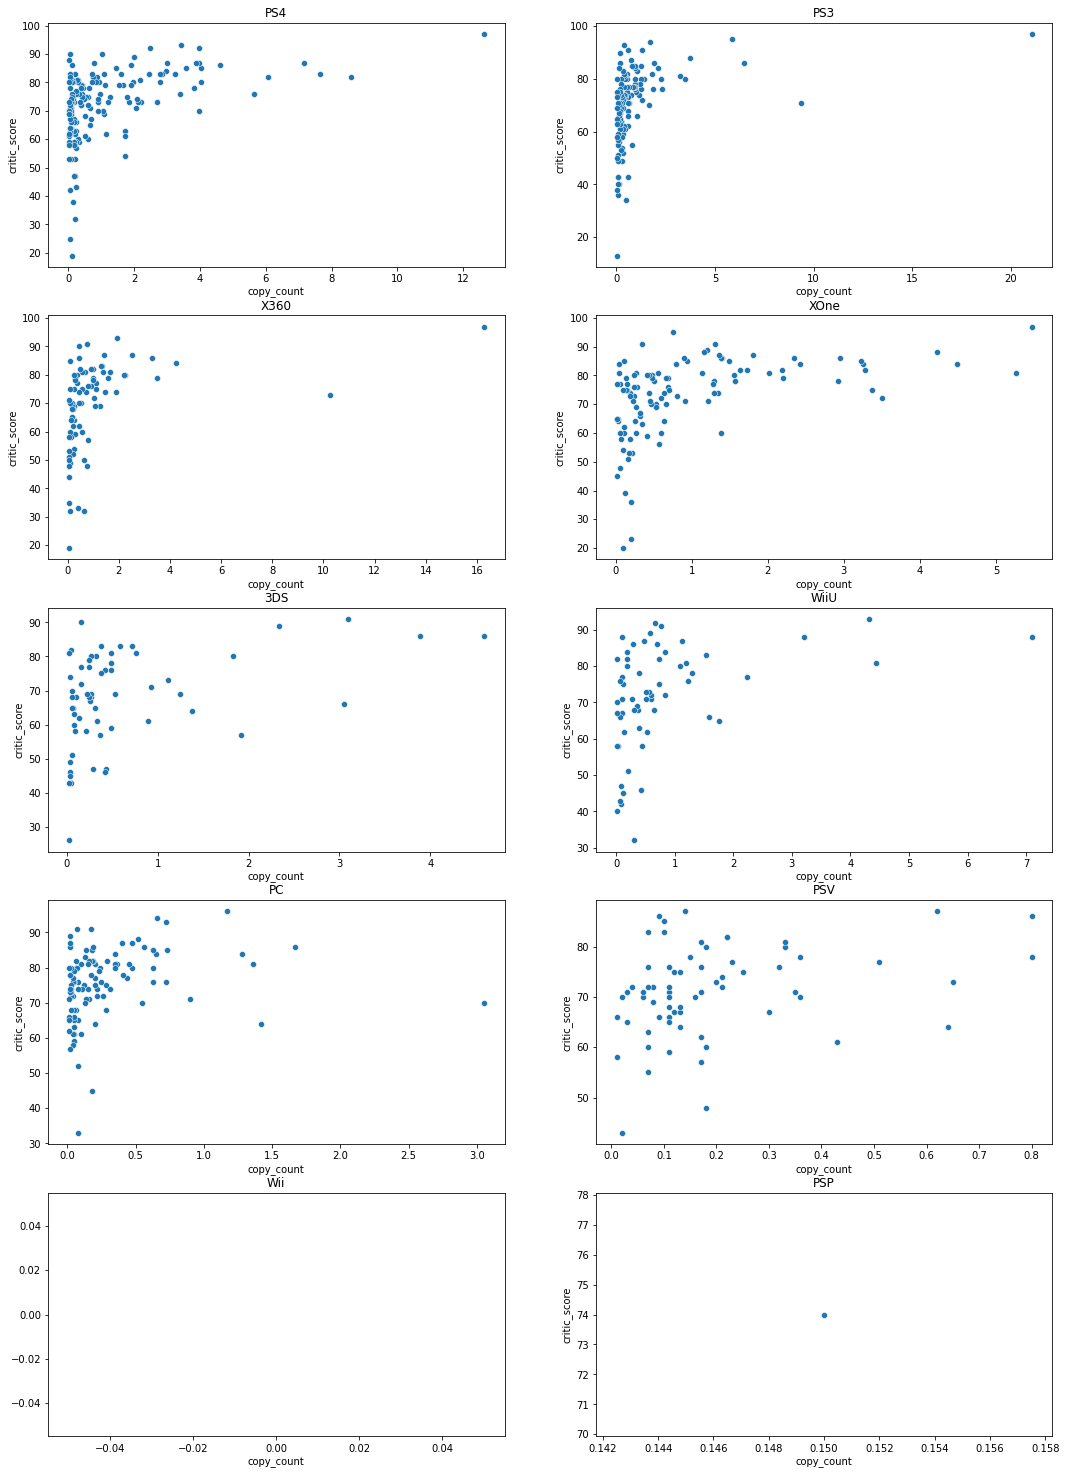

In [34]:
#диаграммы рассеяния для топ-10 платформ - зависимость м/у оценками критиков и продажами
plt.figure(figsize=(18,26))
for i, platform in enumerate(top10):
    
    plt.subplot(5, 2, i+1)
    #df_cut.query('platform ==@platform').plot(x='copy_count', y='user_score', kind='scatter')
    sns.scatterplot(data=df_cut.query('platform ==@platform'), x='copy_count', y='critic_score')
    plt.title(platform)

In [35]:
for score in ['user_score','critic_score']:
    
    df_corr = df_cut.query('platform in @top10')[['platform', score, 'copy_count']]

    df_corr = df_corr.groupby('platform').corr().reset_index()
    
    df_corr = df_corr.query('level_1==@score').sort_values(by='copy_count',ascending=False)[['platform','copy_count']]
   
    if score=='user_score':
        df_corr.columns = ['Платформа','Корреляция м/у оценками пользователей и продажами']
    else:
        df_corr.columns = ['Платформа','Корреляция м/у оценками критиков и продажами']
        
    display(df_corr)

,Платформа,Корреляция м/у оценками пользователей и продажами
12,Wii,0.682942
14,WiiU,0.433476
0,3DS,0.264711
6,PS4,0.024231
10,PSV,0.017515
4,PS3,-0.016333
16,X360,-0.034562
18,XOne,-0.039268
2,PC,-0.129428
8,PSP,-1.000000


,Платформа,Корреляция м/у оценками критиков и продажами
18,XOne,0.459385
6,PS4,0.431848
0,3DS,0.384326
14,WiiU,0.383951
16,X360,0.350345
4,PS3,0.334285
10,PSV,0.303160
2,PC,0.216403
8,PSP,NaN
12,Wii,NaN


In [36]:
print('Количество записей для PSP', df_cut.query('platform =="PSP"')['name'].count())

print('Количество пустых пользовательских оценок для PSP',df_cut.query('platform =="PSP"')['user_score'].isna().sum())

print('Количество пустых оценок критиков для PSP',df_cut.query('platform =="PSP"')['critic_score'].isna().sum())
print()
print('Количество записей для Wii', df_cut.query('platform =="Wii"')['name'].count())

print('Количество пустых оценок критиков для Wii',df_cut.query('platform =="Wii"')['critic_score'].isna().sum())

Количество записей для PSP 67
Количество пустых пользовательских оценок для PSP 65
Количество пустых оценок критиков для PSP 66

Количество записей для Wii 22
Количество пустых оценок критиков для Wii 22


Для одних платформ корреляция между продажами и оценками пользователей очень слабая положительная,  
для других - очень слабая отрицательная.  

Только для платформ Wii и WiiU можно сказать,  
что есть отчетливая положительная зависимость между оценками пользователей и продажами.  

Расчет показал сильную отрицательную корреляцию для PSP,  
но такому результату нельзя доверять, т.к. для этой платформы за 2013-2015 гг.  
есть только две записи с заполненной оценкой пользователй.  

Для всех платформ корреляция между продажами и оценками критиков положительная и  
больше корреляции с оценками пользователей (кроме WiiU и Wii).  
Для PSP и Wii оценок критиков в данных нет.  
Наибольшая положительная корреляция м/у оценками критиков и продажами у PS4 и XOne.  

**Вывод**  
Оценки пользователей практически не влияют на количество продаж, только для Wii и WiiU есть положительная зависимость.  
Связь между оценками критиков и продажами довольно сильная положительная - чем выше оценки, тем лучше продажи.  
Особенно эта корреляция проявляется на двух потенциально прибыльных платформах PS4 и XOne.

### Общее распределение игр по жанрам. 

In [37]:
print('Количество выпущенных игр определенного жанра за 2013-2015 гг.')
df_cut['genre'].value_counts()

Количество выпущенных игр определенного жанра за 2013-2015 гг.


Action          588
Role-Playing    238
Adventure       189
Sports          166
Shooter         140
Misc            123
Fighting         64
Racing           61
Platform         59
Simulation       44
Strategy         43
Puzzle           16
Name: genre, dtype: int64

In [38]:
#сгруппируем данные по жанру и найдем общие продажи для каждого жанра за 2013-2015 гг
genre = (df_cut.pivot_table(index='genre',values='copy_count', aggfunc='sum')
               .sort_values(by='copy_count', ascending=False).reset_index())

#округлим сумму продаж до 2 знаков после запятой
genre['copy_count'] = np.round(genre['copy_count'],2)

Объем рынка – размер рынка определенного товара, выраженный в совокупном объеме продаж товара за расчетный период.  
За расчетный период примем год.  
Рассчитаем объем рынка для каждого жанра как  
медиану продаж игр определенного жанра за 2013-2015 гг (сколько продано за год в среднем).  

Рассчитаем медиану количества выпущенных игр определенного жанра за 2013-2015 гг.  

Рассчитаем среднее количество продаж одной игры по каждому жанру за 2013-2015 гг как:  
медиана продаж / медиана количества выпущенных игр = среднее количество продаж одной игры.

In [39]:
#количество выпущенных игр определенного жанра отдельно в год за 2013-2015 гг
genre_y = df_cut.groupby(['genre', 'year']).agg({'name':'count'}).reset_index()[['genre','name']]

#медиана количества выпущенных игр определенного жанра за 2013-2015 гг
genre_y = genre_y.groupby('genre').agg({'name':'median'}).reset_index()
genre_y.columns = ['genre','median_game_cnt']

In [40]:
#продажи игр по жанрам отдельно в год за 2013-2015 гг
genre_c = df_cut.groupby(['genre', 'year']).agg({'copy_count':'sum'}).reset_index()[['genre','copy_count']]

#медиана продаж игр по жанрам за 2013-2015 гг
genre_c = genre_c.groupby('genre').agg({'copy_count':'median'}).reset_index()
genre_c.columns = ['genre','median_sales']

In [41]:
#соединение данных по жанру
genre_y = pd.merge(genre_y,genre_c,on='genre')

In [42]:
#сколько в среднем приходится продаж на одну игру по жанрам в год
genre_y['sales_per_one'] =  genre_y['median_sales']/ genre_y['median_game_cnt']

genre_y = genre_y.sort_values(by='sales_per_one', ascending=False)[['genre','sales_per_one']]

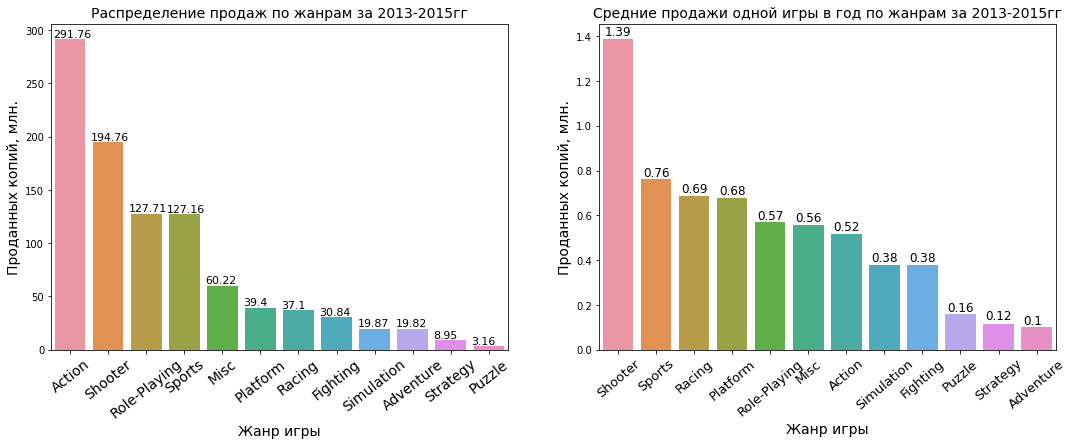

In [43]:
fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(1, 2, 1)
#распределение продаж по жанрам
sns.barplot(x=genre['genre'], y=genre['copy_count'],ax=ax1)

plt.title('Распределение продаж по жанрам за 2013-2015гг',fontsize=14)
plt.xticks(rotation=38,fontsize=14)
plt.xlabel('Жанр игры', fontsize=14)
plt.ylabel('Проданных копий, млн.',fontsize=14)
for x_pos, cnt in zip(np.arange(len(genre)), genre['copy_count']):
    plt.annotate(cnt, xy=(x_pos-0.45, cnt), va='bottom', fontsize=11)   
    
ax2 = fig.add_subplot(1, 2, 2)
#Средние продажи одной игры в год по жанрам
sns.barplot(x=genre_y['genre'], y=genre_y['sales_per_one'],ax=ax2)
plt.title('Средние продажи одной игры в год по жанрам за 2013-2015гг',fontsize=14)
plt.xticks(rotation=40,fontsize=13)
plt.xlabel('Жанр игры', fontsize=14)
plt.ylabel('Проданных копий, млн.',fontsize=14)
for x_pos, cnt in zip(np.arange(len(genre_y)), round(genre_y['sales_per_one'],2)):
    plt.annotate(cnt, xy=(x_pos-0.34, cnt), va='bottom', fontsize=12)

plt.show()

Больше всего за период 2013-2015 гг. продано игр в жанрах Action и Shooter. На третьем месте - Role-playing и Sports.  
Можно предположить, что лучше всего продаются игры,  
требующие от игроков большого количества действий, высокой скорости реакции и большой эмоциональной вовлеченности,  
имитирующие экстремальные обстоятельства (риск, опасность, состязания).  

Меньше всего за этот период продано игр в жанрах Strategy и Puzzle, т.е.требующие или интеллектуальных усилий,  
или, наоборот, состоящие из простых, однообразных действий.  

**Выделяются ли жанры с высокими и низкими продажами?**  
Жанры с самыми высокими и низкими продажами отличаются почти на два порядка.  

**Что можно сказать о самых прибыльных жанрах?**  
График среднего количества продаж одной игры показывает, что  
больше всего продаж приходится на одну единицу игры Shooter - примерно 1 390 000 копий.  
На втором месте Sports - 760 000 копий.  
Тогда как самый продаваемый Action находится на седьмом месте - одна игра в этом жанре продавалась в среднем 520 000 раз.  

Можно сделать вывод, что из-за того, что игр Action издано очень много,  
на каждую из них приходится в среднем небольшое количество проданных копий.  
Игр Shooter и Sports выпущено гораздо меньше - каждая из них могла продаваться большим количеством копий.  
Поэтому одна игра в жанре Shooter или Sports могла принести прибыль больше, чем в жанре Action.  

**Вывод**  
Самые продаваемые жанры - Action, Shooter, Role-playing.  
Но самые прибыльные, скорее всего, Shooter и Sports.

## Портрет пользователя каждого региона

In [44]:
#Функция группирует данные по одному признаку и выводит круговые диаграммы для топ категорий этого признака
#
#Переменнные:    df - датасет,
#                group_col  - колонка группировки, 
#                regions    - словарь, ключ - колонока для агрегации, значение - название диаграммы
#                top_cnt    - сколько записей  из топа нужно отобрать,
#                fsize      - общий размер графика
#                legend_loc - список положений легенды для каждого графика
#
def pie_chart(df, group_col, regions, top_cnt, fsize, legend_loc):
    
    if len(regions)==1:                                #если 1 колонка агрегации
        fig_cols = 1                                   #то у фигуры 1 колонка
        fig_rows = 1                                   # и 1 строка
    else:
        fig_cols = 2                                   #то у фигуры 2 колонки
        fig_rows = len(regions)* -1 // 2 * -1          #и количество строк

    fig, axes = plt.subplots(fig_cols ,fig_rows ,squeeze=False, figsize =fsize)
    axes      = axes.flatten()        
    
    for i, (region_col, region_name) in enumerate(regions.items()):
  
        data_gr= (df.groupby(group_col).agg({region_col:'sum'})
                                       .sort_values(by=region_col,ascending=False).head(top_cnt))
        
        data_gr.plot.pie(y=region_col, autopct = '%0.0f%%', ax=axes[i])
    
        axes[i].set_title(region_name)       
        axes[i].set_ylabel('')  
        
        axes[i].legend(loc=legend_loc[i])
        
    fig.tight_layout()

### Топ-5 популярных платформ по регионам

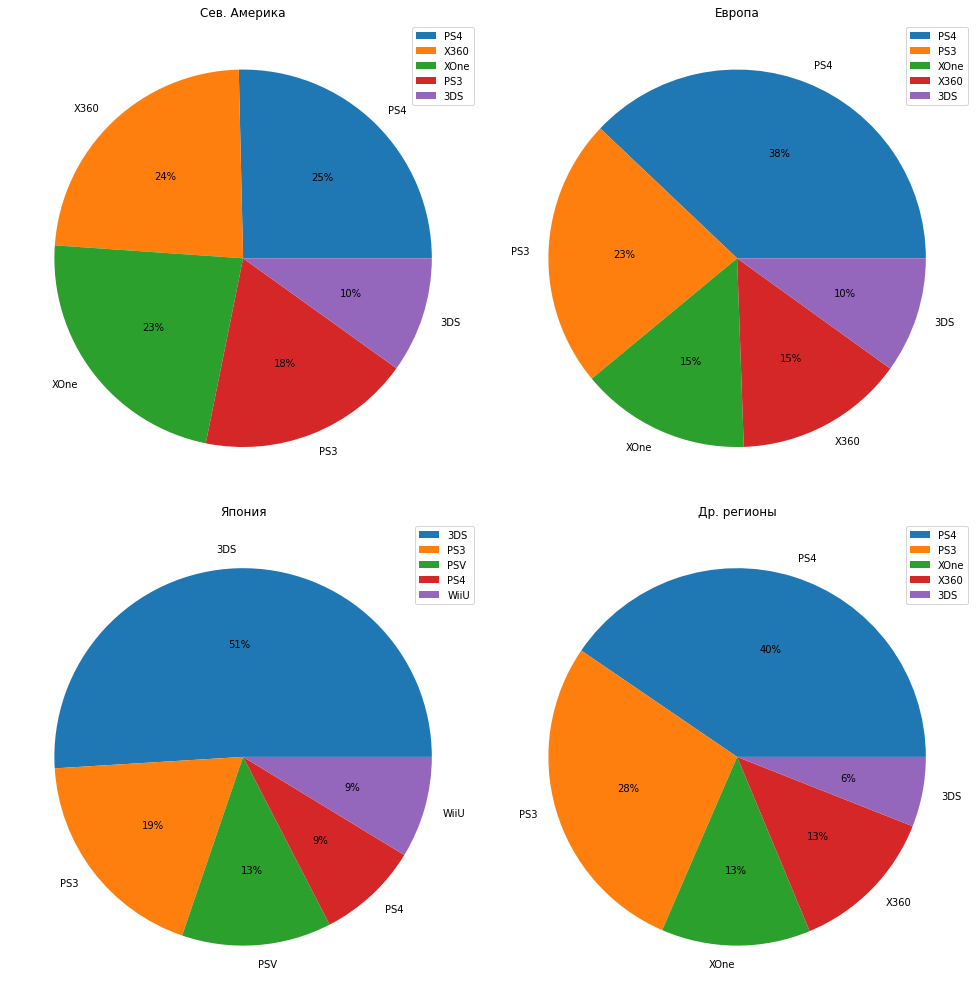

In [45]:
regions = {'na_sales':'Сев. Америка','eu_sales':'Европа','jp_sales':'Япония','other_sales':'Др. регионы'}
        
pie_chart(df_cut, 'platform', regions, 5, (14,14), ['upper right']*4)

В регионах Северная Америка, Европа и Другие регионы самую большую долю продаж занимает PS4, наименьшую - 3DS.  

Платформы занимающие 2-4 места в этих регионах - XOne, PS3, X360.  

Доли варьируются следющим образом:
- Сев. Америка - PS4 - 25%,    X360 - 24%,    XOne - 23%,    PS3 - 18%, 3DS - 10%;
- Европа       - PS4 - 38%, PS3 - 23%,  XOne - 15%, X360 - 15%, 3DS - 10%;
- Др. регионы  - PS4 - 40%, PS3 - 28%,  XOne - 13%, X360 - 13%, 3DS - 6%;  

Распределение долей в Японии сильно отличается от других регионов:  
Лидер и отстающий во всех трех остальных регионах, PS4 и 3DS, в Японии поменялись местами,  
также вместо XOne и X360 здесь присутствуют PSV и WiiU.  
Доли платформ следующие:
-  3DS - 51%,  PS3 - 13%, PSV - 13% PS4 - 9%,  WiiU - 9%.  

Можно отметить, что:  
- PS3, PS4 и 3DS и присутствуют во всех регионах;
- X360 более всего популярна в Сев. Америке;
- в Япониии платформа-лидер 3DS занимает чуть больше половины этого рынка - 51%;  
- доли потенциально прибыльной PS4: в Другие регионы - 40%, в Европе - 38%, в Сев. Америке - 25%, в Японии - 9%;  
- потенциально прибыльная XOne занимает только третье местов в регионах Сев. Америка, Европа, Другие регионы,  
в Японии в топ-5 не входит.

**Вывод**  
Лидеры по регионам в 2013-2015 гг.:  
PS4 - самая популярная платформа в регионах Сев. Америка, Европа, Другие регионы.  
3DS -  самая популярная платформа в регионе Япония.

### Топ-5 популярных жанров по регионам

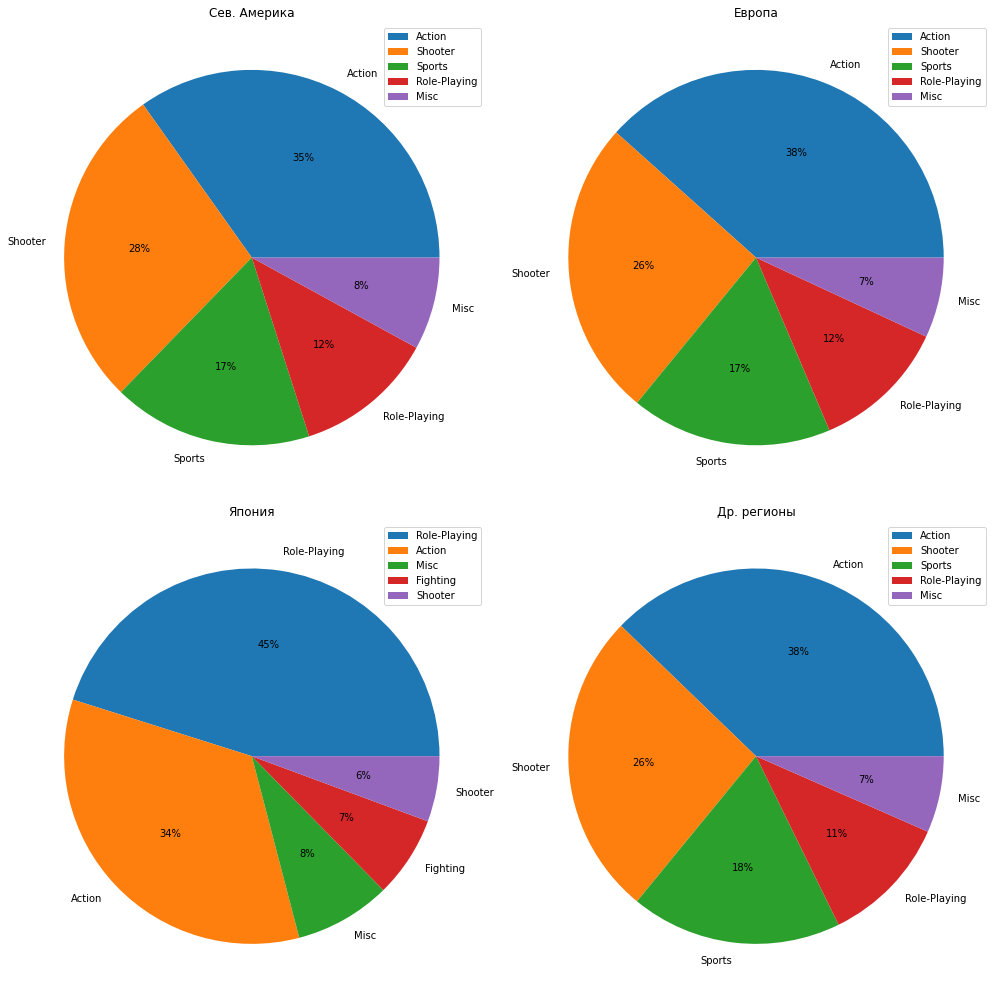

In [46]:
pie_chart(df_cut, 'genre', regions, 5, (14,14), ['upper right']*4)

Предпочтения пользователей по жанрам в регионах  Северная Америка, Европа и Другие регионы  одинаковы,  
различия в долях незначительны, на 1-3%.  
Жанры-лидеры Action и Shooter (различия в долях 7-12%), наименее популярный жанр - Misc.  

Доли распределены следующим образом:  
- Сев. Америка - Action - 35%,    Shooter - 28%,    Sports - 17%,    Role_playing - 12%, Misc - 8%;
- Европа       - Action - 38%,    Shooter - 26%,    Sports - 17%,    Role_playing - 12%, Misc - 7%;
- Др. регионы  - Action - 38%,    Shooter - 26%,    Sports - 18%,    Role_playing - 11%, Misc - 7%.  

Предпочтения пользователей в Японии сильно отличаются от трех других регионов:  

- Role-playing - 45%, Action - 34%,    Misc - 8%,    Fighting - 8%,     Shooter - 6%.  

Доля игр в жанре Action очень близка во всех регионах - 34-38%, отличия на 1-4%.  
В Японии жанр-лидер Role-playing занимает чуть менее половины этого рынка - 45%.  

**Вывод**  
Лидеры по регионам в 2013-2015 гг.:  
Action, Shooter - самые популярные игровые жанры в регионах Сев. Америка, Европа, Другие регионы.  
Role-playing, Action - самые популярные игровые жанры в регионе Япония.

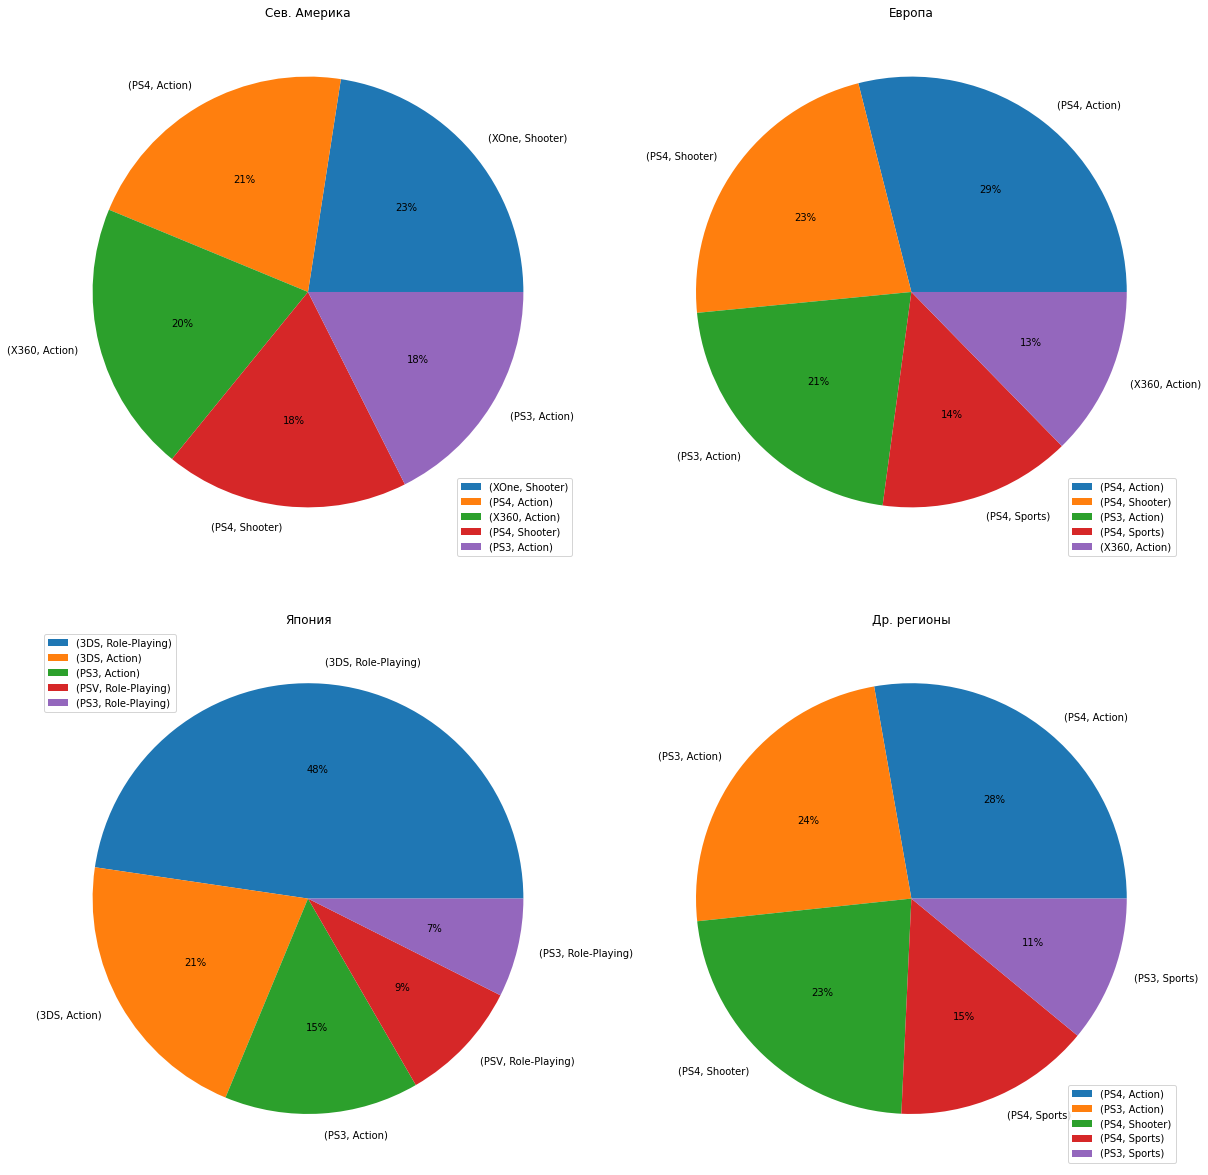

In [47]:
pie_chart(df_cut,['platform','genre'],regions, 5, (17,17)
          ,['lower right','lower right','upper left','lower right'])

Лидеры регионов в разрезе платформы и жанра игры:  
- Сев. Америка - XOne-Shooter - 23%, PS4-Action - 21%, X360-Action - 20%, PS4-Shooter - 18%, PS3-Action - 18%;
- Европа       - PS4-Action - 29%, PS4-Shooter - 23%, PS3-Action - 21%, PS4-Sports - 14%, X360-Action - 13%;
- Др. регионы  - PS4-Action - 28%, PS3-Action - 24%, PS4-Shooter - 23%, PS4-Sports - 15%, PS3-Sports - 11%;
- Япония       - 3DS-Role-playing - 48%, 3DS-Action - 21%, PS3-Action - 15%, PSV-Role-playing - 9%, PS3-Role-playing - 7%.

Общее сочетание для всех рынков: PS3-Action.  
Но платформа PS3 на 2016 год существует уже 11 лет.  
Возможно, исходя из среднего времени жизни платформы, в следующие годы продажи игр под нее будут сокращаться.

**Вывод**  
 
Потенциально прибыльные конфигурации, охватывающие сразу три рынка, Сев. Америка, Европа, Другие регионы:  
платформа - PS4, жанр - Action и  
платформа - PS4, жанр - Shooter.  

Отдельно для Сев. Америки:  
платформа - XOne,  жанр - Shooter.

Отдельно для Японии самые перспективные сочетания:  
платформа - 3DS, жанр - Role-playing и  
платформа - 3DS, жанр - Action.

### Влияние возрастного рейтинга ESRB на продажи по регионам

In [48]:
for i, (region_col, region_name) in enumerate(regions.items()):

    df_corr = df_cut[[region_col, 'rating_int']].corr()
    
    print('Корреляция м/у возрастным рейтингом игр и продажами в регионе', region_name)    
    print(df_corr.values[0,1])
    print()
    print('Есть исчезающе малая корреляция между рейтингом и продажами в изучаемых регионах.')

Корреляция м/у возрастным рейтингом игр и продажами в регионе Сев. Америка
0.19573091515015661

Есть исчезающе малая корреляция между рейтингом и продажами в изучаемых регионах.
Корреляция м/у возрастным рейтингом игр и продажами в регионе Европа
0.17820743089048985

Есть исчезающе малая корреляция между рейтингом и продажами в изучаемых регионах.
Корреляция м/у возрастным рейтингом игр и продажами в регионе Япония
-0.07379956247155613

Есть исчезающе малая корреляция между рейтингом и продажами в изучаемых регионах.
Корреляция м/у возрастным рейтингом игр и продажами в регионе Др. регионы
0.1839256485975447

Есть исчезающе малая корреляция между рейтингом и продажами в изучаемых регионах.


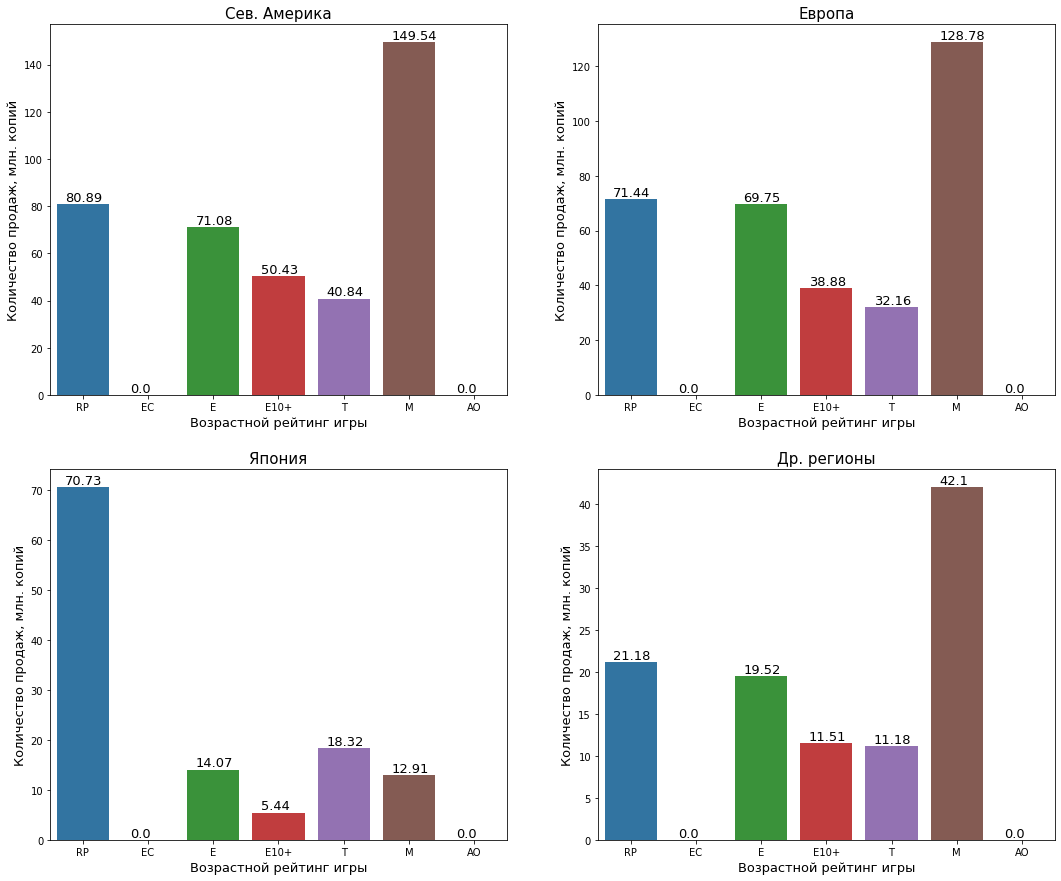

In [49]:
#зависимость м/у возрастным рейтингом и продажами
plt.figure(figsize=(18,15))
for i, (region_col, region_name) in enumerate(regions.items()):
    
    plt.subplot(2, 2, i+1)

    data_gr = df_cut.pivot_table(index='rating_int',values=region_col, aggfunc='sum')
    data_gr.loc[1] = 0
    data_gr.loc[6] = 0
    data_gr = data_gr.sort_index()

    sns.barplot(data_gr.index, y=data_gr[region_col])

    plt.xlabel('Возрастной рейтинг игры', fontsize=13)
    plt.xticks(list(df['rating_int'].sort_values().unique()), ['RP', 'EC','E', 'E10+', 'T', 'M', 'AO'] )
    plt.ylabel('Количество продаж, млн. копий', fontsize=13)
    
    for x_pos, cnt in zip(np.arange(len(data_gr)), round(data_gr[region_col],2)):
        plt.annotate(cnt, xy=(x_pos-0.27, cnt), va='bottom', fontsize=13)
       
    plt.title(region_name, fontsize=15)

In [50]:
cnt  = df_cut.query('rating=="RP"')['rating'].count()/len(df_cut)
print(f'Количество игр без рейтинга: { cnt: .2%}')

Количество игр без рейтинга:  43.62%


Расшифровка значений в столбце 'рейтинг':  
«EC» - Early childhood (дошкольники),  
«E» - Everyone (для всех возрастов),  
«E10+» - Everyone 10 and older (от 10 лет и выше),    
«T» - Teen (от 13 лет и выше),  
«M» - Mature (от 17 лет и выше),  
«AO» - Adults Only 18+ (только для взрослых, от 18 лет и выше),  
«RP» - Rating Pending (рейтинг еще не присвоен).  

Определить точно влияние рейтинга на продажи по данной выборке затруднительно,  
т.к. 43.62% записей имеют значение «RP» , т.е. "рейтинг еще не определен".  
Если рассматривать все значения кроме «RP» , можно заметить, что:  
 - в данной выборке нет игр с рейтингом «EC» и «AO»;  

 - в регионах Северная Америка, Европа и Другие регионы самые покупаемые игры имеют рейтинг «M», «E» и «E10+»;   
 - в регионе Япония - «T», «E» и «M».  
 
Но сказать, что рейтинг имеет влияние на продажи будет неправильно, скорее всего,  
не рейтинг влияет на продажи игр, а те игры, которые больше всего покупают,  имеют определенный рейтинг.  
На покупки большее влияние оказывают жанр, популярность, личные предпочтения, цена.  

**Вывод**  
Рейтинг ESRB не оказывает влияния на продажи,  
но есть различия между Японией и остальными регионами, в том, игры с каким рейтингом больше продаются.

## Проверка гипотез

In [51]:
#выборки по платформам
xone = df_cut.query('platform=="XOne"')['user_score'].dropna()

pc = df_cut.query('platform=="PC"')['user_score'].dropna()

In [52]:
#вычисляем размеры выборок по платформам
print(xone.nunique(), pc.nunique())


41 52


In [53]:
#выборки по жанрам
action = df_cut.query('genre=="Action"')['user_score'].dropna()

sports = df_cut.query('genre=="Sports"')['user_score'].dropna()

In [54]:
#вычисляем размеры выборок по жанрам
print(action.nunique(),sports.nunique())

61 55


**Как будем работать с гипотезами.**  
Нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства.  
Если мы выясняем, есть ли разница между совокупностями, то нулевая гипотеза будет: «разницы нет, исследуемые параметры равны».  
Альтернативная гипотеза должна противоречить нулевой гипотезе, она принимается в случае отбрасывания нулевой.  
В нашем случае альтернативная гипотеза двусторонняя, т.к. возможно отклонение и в большую, и в меньшую стороны. 

**Какой критерий будем использовать для проверки гипотез и почему.**  
Будем использовать специальный метод для проверки гипотезы  
о равенстве среднего двух ген. совокупностей по взятым из них выборкам: scipy.stats.ttest_ind.  
Он работает на основе t-распределения (распределение Стьюдента) и поэтому называется t-тестом.  

Если значений в выборке много (30 и больше),  
то распределение Стьюдента настолько близко к нормальному, что можно взять нормальное распределение.  
Но принято просто каждый раз применять t-тест — ведь он работает для выборки любого размера.

t-тест можно применять, если:

1.Генеральные совокупности не зависят друг от друга. Данное условие выполняется.  

2.Выборочные средние должны быть нормально распределены.  

   Из Центральной предельной теоремы известно,  
   если размер выборки составляет 30 и больше значений,   
   выборочные средние, которые можно получить из одной и той же ген. совокупности,  
   будут распределены нормально вокруг истинного среднего этой совокупности.  
   
   Это утверждение верно, даже если сама генеральная совокупность не распределена нормально.  
  
   В нашем случае размеры выборок 41-52 (платформы) и 61-55 (жанры), значит, условие выполняется. 
  
3.Дисперсии генеральных совокупностей равны.  
   В нашем случае дисперсии  ген. совокупностей неизвестны, и выборки разного размера, поэтому  
   для проведения теста укажем параметр equal_var = False, дисперсии выборок посчитаются по отдельности.  
 
Метод scipy.stats.ttest_ind возвращает два значения -  
статистику разности (t-разность) и уровень значимости для этой статистики (p-value).  
Статистика разности — это количество стандартных отклонений между выборочным средним двух выборок.  
Точное решение принимается по p-value. Оно показывает вероятность случайно получить такое или большее различие.

### Средние пользовательские оценки игр на  платформах Xbox One и PC одинаковые.

Формулировка гипотезы:  
H0: Средняя пользовательская оценка платформы Xbox One равна средней пользовательской оценке PC.  
H1: Средняя пользовательская оценка платформы Xbox One НЕ равна средней пользовательской оценке PC.

Возьмем критический уровень статистической значимости равный 5%, alpha = 0.05.

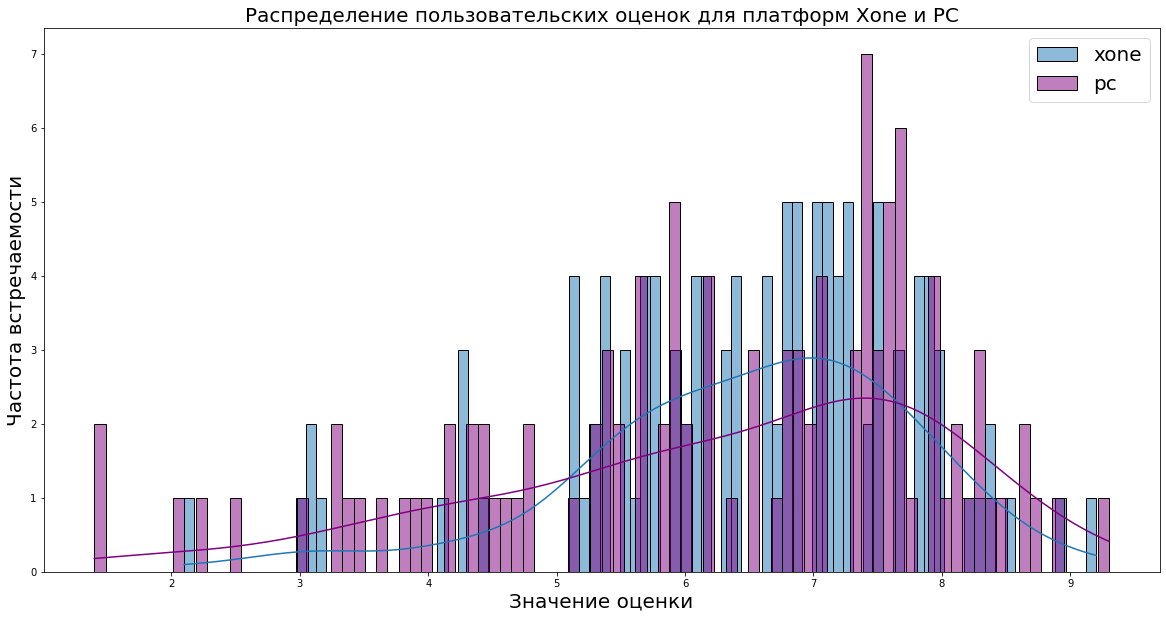

In [55]:
#гистограммы распределений оценок
plt.figure(figsize=(20,10))
plt.title('Распределение пользовательских оценок для платформ Xone и PC',fontsize=20) 
plt.ylabel('Частота встречаемости',fontsize=20)
plt.xlabel('Значение оценки', fontsize=20)

sns.histplot(xone, bins=90, kde=True, label ='xone')
sns.histplot(pc, bins=90, kde=True, color ='purple', label ='pc')

plt.legend(fontsize=20)
plt.show()

In [56]:
alpha = 0.05      #критический уровень статистической значимости

results = st.ttest_ind(xone, pc, equal_var = False)

print('t-разница = %.3f' % results.statistic)
print('p-value:', results.pvalue)
print()

if (results.pvalue < alpha):
    print('p-value меньше 5%. Отвергаем нулевую гипотезу.')
    print('Принимаем альтернативную гипотезу:')
    print() 
    print('«Средняя пользовательская оценка Xbox One НЕ равна средней пользовательской оценке PC».')
else:
    print('p-value больше 5%. Не получилось отвергнуть нулевую гипотезу.')
    print('Принимаем нулевую гипотезу:')
    print()
    print('«Средняя пользовательская оценка Xbox One равна средней пользовательской оценке PC».')

t-разница = 1.068
p-value: 0.2867036680187632

p-value больше 5%. Не получилось отвергнуть нулевую гипотезу.
Принимаем нулевую гипотезу:

«Средняя пользовательская оценка Xbox One равна средней пользовательской оценке PC».


**Вывод**  
t-разница очень мала, p-value равна 28.6% (гораздо больше выбранного уровня значимости в 5%) т.е.,  
вероятность получить такую разницу случайно очень высока.  
С вероятностью в 28.6% можно получить одинаковые оценки двух платформ.

При условии, что гипотеза H0 верна, данные выборок по платформам XOne и PC не противоречат тому, что  
cредняя пользовательская оценка Xbox One равна средней пользовательской оценке PC.

### Средние пользовательские оценки жанров Action и Sports разные.

Формулировка гипотезы:  
H0: Средняя пользовательская оценка жанра Action равна средней пользовательской оценке жанра Sports.  
H1: Средняя пользовательская оценка жанра Action НЕ равна средней пользовательской оценке жанра Sports.  

Возьмем критический уровень статистической значимости равный 5%, alpha = 0.05.

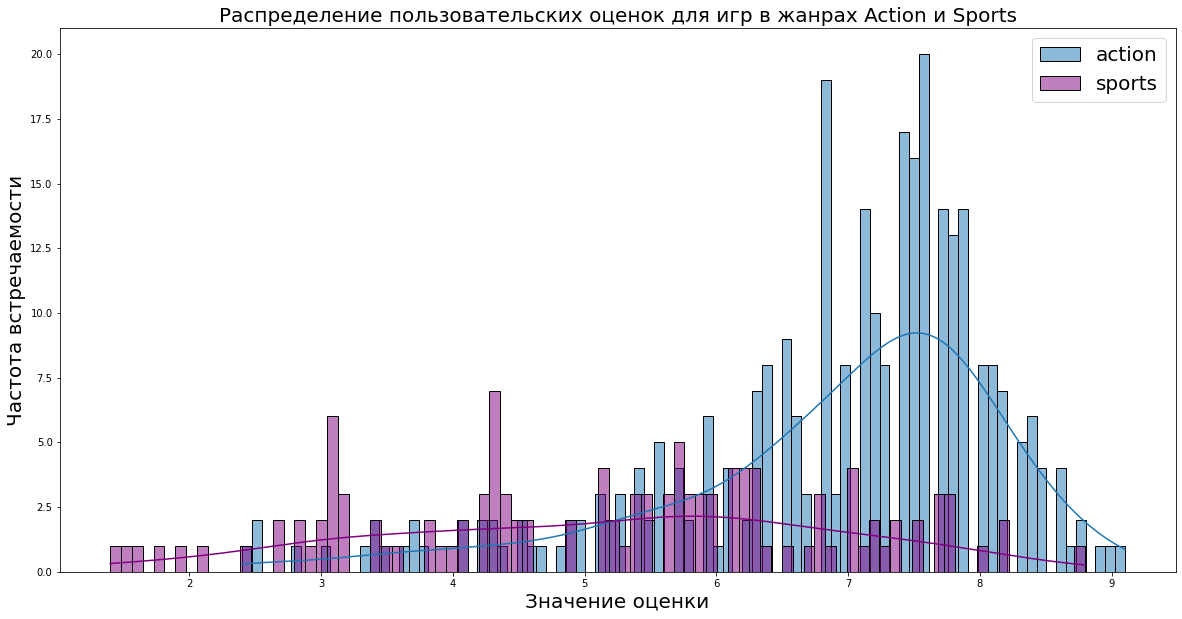

In [57]:
#гистограммы распределений оценок
plt.figure(figsize=(20,10))
plt.title('Распределение пользовательских оценок для игр в жанрах Action и Sports',fontsize=20) 
plt.ylabel('Частота встречаемости',fontsize=20)
plt.xlabel('Значение оценки', fontsize=20)

sns.histplot(action, bins=90, kde=True, label ='action')
sns.histplot(sports, bins=90, kde=True, color ='purple', label ='sports')

plt.legend(fontsize=20)
plt.show()

In [58]:
alpha = 0.05      #критический уровень статистической значимости

results = st.ttest_ind(action, sports, equal_var = False)

print('t-разница = %.3f' % results.statistic)
print('p-value:', results.pvalue)
print()

if (results.pvalue < alpha):
    print('p-value меньше 5%. Отвергаем нулевую гипотезу.')
    print('Принимаем альтернативную гипотезу:')
    print() 
    print('«Средняя пользовательская оценка Action НЕ равна средней пользовательской оценке Sports».')
else:
    print('p-value больше 5%. Не получилось отвергнуть нулевую гипотезу.')
    print('Принимаем нулевую гипотезу:')
    print()
    print('«Средняя пользовательская оценка Action равна средней пользовательской оценке Sports».')

t-разница = 10.058
p-value: 3.5076737062533683e-19

p-value меньше 5%. Отвергаем нулевую гипотезу.
Принимаем альтернативную гипотезу:

«Средняя пользовательская оценка Action НЕ равна средней пользовательской оценке Sports».


**Вывод**  
t-разница очень большая, т.е., вероятность получить ее случайно очень низка.    
p-value сильно меньше выбранного уровня значимости.  
Есть статистически значимые различия между выборками.  
С исчезающе малой вероятностью можно получить одинаковые оценки двух жанров.

При условии, что гипотеза H0 верна, данные выборок по жанрам Action и Sports противоречат тому, что  
cредняя пользовательская оценка жанра Action равна средней пользовательской оценке жанра Sports.  

По наблюдаемым данным можно сделать предположение, что верна альтернативная гипотеза H1 -  
cредние пользовательские оценки жанров Action и Sports различаются.

## Общий вывод

### Ход исследования  

Удалено незначительное количество записей с пустыми критическими значениями - 'название игры', 'год выпуска', 'жанр'.  
Данные приведены к корректным типам.  

Произведена замена неявных дубликатов и пустых значений на логически корректные в столбце 'рейтинг'.  
Произведена замена значения 'tbd'(будет определено) на пустое значение в столбце 'оценка пользователей'.  
Пропуски в столбцах 'оценка пользователей' и 'оценка критиков' оставлены намеренно,  
т.к. любое заполнение исказит результаты корреляционного анализа и статтеста.  

Проанализированы:  
- общее количество выпущенных игр по годам за весь период,  
- изменения продаж по топ-10 платформам,  
- актуальный период, подходящий для исследования,  
- лидирующие, растущие, падающие платформы в актуальноем периоде,  
- глобальные продажи игр в разрезе платформ,  
- влияние оценок пользователей и критиков на продажи,  
- распределение игр по жанрам,  
- топ-5 платформ, жанров и их сочетаний в разрезе регионов,  
- влияние рейтинга ESRB на продажи.

Проверены гипотезы:  
- "Средние пользовательские оценки игр на платформах XOne и PC одинаковые",  
- "Средние пользовательские оценки жанров Action и Sports разные".  

Выявлены признаки потенциально популярной игры.

###  

Количество видеоигр для консолей начало расти с большой скоростью с 1994 г.  
В промежутке 1980-2016 гг максимальное количество игр  выпущено в 2008 г. - 1427 штук и в 2009 г. - 1426 штук.  
Больше всего игр за весь период продано для PS2, X360, PS3, Wii, DS.

Резкий спад выпуска игр произошел в 2012 г.  
В 2013 - 2016 гг. на всем рынке видеоигр заметна тенденция к падению.  

За минимальный порог продаж в год принято 10 млн. копий игры.  
По топ-10 платформ за весь период и минимальный порог расчитано среднее время жизненного цикла платформы - 6 лет.  
Актуальный период для исследования - половина этого срока, 3 года.  
Т.к. данные за 2016 год могут быть неполными, анализ проводится по 2013-2015 гг. включительно.

Платформы-лидеры на глобальном рынке на промежутке 2013-2015 гг. - PS4 и XOne.  
Их можно рассматривать как потенциально прибыльные в будущем.  
На региональных рынках лидеры различаются.

Данные по продажам сильно изменчивы, при этом есть несколько игр-лидеров по количеству продаж.  
Даннные о средних значениях продаж потенциально прибыльных XOne и PS4 за 2013-2015 гг. очень близки.  
Медиана XOne - 360 000 проданых копий, PS4 - 310 000 копий.

Оценки пользователей практически не влияют на количество продаж.  
Только для платформ Wii и WiiU есть сильная положительная зависимость.   

Корреляция между оценками критиков и продажами довольно заметная, положительная,  
оценки критиков сильнее влияют на продажи, чем оценки пользователей.  
Эта корреляция особенно сильна для потенциально прибыльных PS4 и XOne.

Больше всего выпущено игр в 2013-2015 гг. в жанрах Action - 588 штук и Role-Playing - 238 штук.  
Самые продаваемые игры в жанрах Action - 291.76 млн. копий и Shooter - 194.76 млн. копий.  
Самый малопродаваемый жанр puzzle - 3.16 млн. копий.  
Жанры с самыми высокими и низкими продажами отличаются почти на два порядка (почти 300 и 3 млн. копий).  

Потенциально самые прибыльные, скорее всего,  жанры Shooter и Sports.

###  
Лидеры региональных рынков в 2013-2015 гг..  

Распределение долей в Японии сильно отличается от других регионов:  
Лидер и отстающий во всех трех остальных регионах, PS4 и 3DS, в Японии поменялись местами.

PS4 - самая популярная платформа в регионах Сев. Америка, Европа, Другие регионы. Последнее место у платформы 3DS.  
3DS - самая популярная платформа в регионе Япония, занимает чуть больше половины этого рынка. PS4 здесь занимает 4 место в топ-5.

Action, Shooter - самые популярные игровые жанры в регионах Сев. Америка, Европа, Другие регионы.  
Role-playing, Action - самые популярные игровые жанры в регионе Япония.

Сочетание PS3-Action присутствует во всех регионах.  

Определить точно влияние рейтинга на продажи затруднительно,  
т.к. 43.62% записей имеют значение «RP» , т.е. "рейтинг еще не определен".  
Если записи с  «RP» не рассматривать, то можно заметить, что:  
 - в регионах Северная Америка, Европа и Другие регионы самые покупаемые игры имеют рейтинг «M», «E» и «E10+»;   
 - в регионе Япония - «T», «E» и «M».  
 
Возрастной рейтинг не влияет на продажи игр, но есть различия по регионам  в том, игры с каким рейтингом больше продаются.  
На покупку большее влияние оказывает жанр, популярность, личные предпочтения, цена.

###  
При условии, что гипотеза верна, данные выборок по платформам XOne и PC не противоречат тому, что  
cредняя пользовательская оценка Xbox One равна средней пользовательской оценке PC.  

При условии, что гипотеза верна, по данным выборок по жанрам Action и Sports можно сделать предположение,  
что cредние пользовательские оценки жанров Action и Sports различаются.

### Заключение  
Исследование проводилось с целью выявить закономерности, определяющие успешность игры.  

На основании полученных результатов можно предположить, что  
потенциально популярный продукт сразу для трех регионов,  

Северная Америка, Европа, Другие регионы -  
игра в жанре Action  или Shooter, выпущенная для платформы PS4. 

Отдельно для региона Северная Америка - игра в жанре Shooter, выпущенная для платформы XOne.

Отдельно для региона Япония -  
игра в жанре Role-playing или Action, выпущенная для платформы 3DS.  

Также у этой игры должны быть высокие оценки критиков.